# figure A2, LQR region of attraction

In [1]:
import numpy as np
from scipy.integrate import odeint  
from operator import sub 
import controlpy   
import pickle

from matplotlib import  rc    
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import rcParams 

import sys 
import  os 

# append function path to system
base_path = os.path.dirname( os.getcwd()  )  
function_path = os.path.join(  base_path, 'functions') 
sys.path.append(function_path ) 
 
figs_path = os.path.join(  base_path, 'figs') 
data_path = os.path.join(  base_path, 'data')
    
# import custom functions 
from figure_settings import *    
import figure_functions as ff
import phasediagram as phd
import singlependulum as sp  

In [2]:
# General Plotting Parameters 
fig_dim = (6.2, 2.2 )  
fig_name = 'figA2_LQR_boundary'
LQR_limit = 0.3

In [3]:
A = np.matrix([[0.,1.],[-10.,0. ]])
B = np.matrix([[0.],[1.]])
Q = np.matrix([[11., 0.],[0.,1.]])*1e4
R = np.matrix([1.])  

K,__,__ = controlpy.synthesis.controller_lqr(A,B,Q,R)  

In [4]:
def plot_LQR_region( ax_p):
    nx = 2
    ny = 10 
 
    y_f = np.array([np.pi,0])

    dt = 0.01; 
    tLast = 4
    tInt = np.arange(0,tLast+dt, dt)    

    result_list = []
    
    ny = 10
    dth_range = np.linspace(1,5.,ny) 
    th_range = dth_range*0 + 0.15  +np.pi
    dth_mat = np.vstack( (th_range,dth_range)  ).transpose()
    dth_mat[0]

    for j in range(ny): 
        
        th0 = dth_mat[j,0]
        dth0 = dth_mat[j,1] 
        
        y0 = np.array( [th0,dth0] )  
        new_point = y0
        point1 = np.array([np.pi-0.3, 1.88])
        point2 = np.array([np.pi+0.3, 0]) 
        point3 = np.array([np.pi-0.3, 0])
        point4 = np.array([np.pi+0.3, -1.88])

        slope = (point2[1]-point1[1])/(point2[0]-point1[0])
        new_point = y0 
        maxy_in = point1[1]+(new_point[0]-point1[0])*slope
        miny_in = point3[1]+(new_point[0]-point3[0])*slope

        LQR_inx = ((y0[0]> visible_x[0]) & (y0[0] < visible_x[1])  )   
        LQR_iny  =  (new_point[1] < maxy_in) & (new_point[1] > miny_in) 
        LQR_bool = LQR_inx & LQR_iny 
        if LQR_bool:
            y = odeint( pendulum_dynamics,y0, tInt , args=(K,)   ) 
        else:
            y = odeint( pendulum_dynamics,y0, tInt , args=(K*0,)   )  
        err = y_f - y
        u = [ np.clip(np.dot( K,e),-3,3) for e in err ]  

        converge_bool = np.linalg.norm( err[-1] ) <1e-3 
        result_list.append( [y0,converge_bool,y,u] ) 
            
    bool_conv = [ list[1] for list in result_list] 
    IC = [ list[0] for list in result_list]       
   
    filename_minimal = os.path.join( data_path,  'feedforward_grouping_minimal_set.pkl')
    with open( filename_minimal, 'rb') as f:
        mynewlist = pickle.load(f)
    u_param, dth_start, dth_end = mynewlist 
 
    u_list = []  

    phd.homoclinic_plot(ax_p ,0,2*np.pi, col = homoclinic_col )  
    ax_p.set_xlim( np.array([-1,1])*.8+np.pi)
    ax_p.set_ylim( np.array([-1,1])*5 )  
    x_lim = np.pi - LQR_limit 
    L = 16
    rectangle1 = plt.Rectangle( (0,-L/2), visible_x[0],L, 
                                zorder=-5, facecolor = obscure_col ,alpha = obscure_alpha, edgecolor=obscure_edge) 
    ax_p.add_patch(rectangle1)
    rectangle2 = plt.Rectangle( (visible_x[1],-L/2), 2*np.pi,L, 
                                zorder=-5, facecolor = obscure_col ,alpha = obscure_alpha, edgecolor=obscure_edge) 
    ax_p.add_patch(rectangle2) 
    dx = LQR_limit 

    x_points = np.array([-dx, dx, dx, -dx])+np.pi
    y_points = np.array([1.,0,-1.,0])*1.88
    ax_p.fill( x_points, y_points,facecolor=lqr_fill, zorder = -6,alpha=0.1) 

    for j,(st, end) in enumerate(zip(dth_start,dth_end)) : 

        x_loc = np.array([-1,1])*0.03+np.pi+LQR_limit
        y_loc = np.array([1,1])*st
        ax_p.plot(x_loc,y_loc,'k')
        ax_p.plot( np.array([1,1])*np.pi+ LQR_limit , [0,8], color= 'k') 
        y_text = np.average([st,end]) -0.1
#         ax_p.text( np.pi+fp.LQR_limit + 0.2  , y_text+0.1+ 0.6, 'U'+str(j), color=text_col, fontsize = u_size )

        ax_p.text( np.pi+LQR_limit - 0.13  , y_text , 'U'+str(j), fontsize = 6)

 
        if np.mod(j,2) == 0:
            delta_th = end-st
            vx = 1
            grad = 3
            x_points = np.array([0,1,1,0])*vx + np.pi + 0.3  
            y_points = np.array([  delta_th, delta_th+grad*vx,grad*vx,0])  + st

            ax_p.fill( x_points, y_points,facecolor='r',edgecolor='r', zorder = 3,alpha=0.1) 

        
    ax_p.yaxis.set_major_locator( plt.MultipleLocator(4) ) 
    ax_p.xaxis.set_major_locator(plt.MultipleLocator(np.pi )) 
    ax_p.xaxis.set_major_formatter(plt.FuncFormatter(phd.multiple_formatter()))   
     
    return( ax_p ) 
 

In [5]:
def pendulum_dynamics( y_n, t , K  ):
    L = 1. 
    mp = 1. 
    g = -10.
    b = 0.01
    y_f = np.array([np.pi,0])
       
    u = np.clip( np.dot( K,(y_f -y_n) ) ,-3,3)  
    
    fy = np.zeros(y_n.shape)    
    fy[0]=    y_n[1]  
    fy[1] =    mp*L*g/(mp*L**2)*np.sin( y_n[0] ) -b/(mp*L**2)*y_n[1] + u/(mp*L**2)
    return fy

In [6]:
# def pendulum_dynamics_discrete( y_n, t , K  ):
dt = 0.001; 
tLast = 4
tInt = np.arange(0,tLast+dt, dt) ;
n_steps = np.int(tLast/dt)
print('Number of time steps: '+ str(n_steps) )
t = np.array([0,dt]) 
time_sign = 1

y0 = np.array([np.pi - 0.2,0.1]) 


def pendulum_dynamics_discrete( y0, t , K  ):
    un = 0.
    y = []
    u = [] 
    

    for j in range(n_steps):
            y.append(y0)  
            u.append(un)  
    #         c_type.append(control_type) 

            y1 = odeint(  sp.pendulum_ode, y0,  t, args=(un ,time_sign,)  )[1]     # ode solver   

            ytemp_prior = y0.copy()
            ytemp_prior[0] = sp.wrap2periodic(y0[0],2*np.pi,np.pi)
            ytemp = y1.copy()
            ytemp[0] = sp.wrap2periodic(y1[0],2*np.pi,np.pi)

            LQR_inx = ((ytemp[0]> visible_x[0]) & (ytemp[0] < visible_x[1])  )  

            point1 = np.array([np.pi - LQR_limit , 1.88])
            point2 = np.array([np.pi + LQR_limit , 0]) 
            slope = (point2[1]-point1[1])/(point2[0]-point1[0])
            new_point = ytemp

            maxy_in = point1[1]+(new_point[0]-point1[0])*slope
            
            
            point3 = np.array([np.pi - LQR_limit , 0])
            point4 = np.array([np.pi + LQR_limit , -1.88]) 
            slope = (point4[1]-point3[1])/(point4[0]-point3[0])
            new_point2 = ytemp

            miny_in = point3[1]+(new_point2[0]-point3[0])*slope
            
            
            
            
            LQR_iny =  (new_point[1] < maxy_in ) & (new_point2[1] > miny_in ) 

            LQR_bool = LQR_inx & LQR_iny


            un = 0. 
            if LQR_bool:  
                un = np.clip( np.dot( K,(y_f -ytemp) ) ,-3,3)[0,0]   

            y0 = y1 
 
    y= np.array(y)
    u= np.array(u)
    
    return y,u

# plt.plot(y[:,0],y[:,1])

Number of time steps: 4000


In [7]:
dt = 0.01; 
tLast = 4
tInt = np.arange(0,tLast+dt, dt)   
L =  1.
g = -10.      


nx = 9
ny = 9
th = np.linspace(-1.,1.,nx)*0.5 + np.pi
dth = np.linspace(-1.,1.,nx)*3

TH, DTH = np.meshgrid(th,dth) 

y_f = np.array([np.pi,0])
 
result_list = []
for th0 in th:
    for dth0 in dth: 
        y0 = np.array( [th0,dth0] ) 
          
        y,u = pendulum_dynamics_discrete(y0,t, K) 
        err = y_f - y 
        
        converge_bool = np.linalg.norm( err[-1] ) <1e-3
        
        result_list.append( [y0,converge_bool,y,u] )
        
bool_conv = [ list[1] for list in result_list] 
IC = [ list[0] for list in result_list] 
        
        
        

In [8]:
# fig,ax = plt.subplots(1,1,figsize=(10,6) ) 
# # result_list[0][2]
# u_list = [] 
# for list in result_list:
#     list[3][1]
    
#     u_list.append( list[3][0])
#     if list[1]:
#         col = 'black'
#     else:
#         col = 'red'
#     converge_bool = list[0]
    
#     dist_err = np.abs(list[2][:,0] - np.pi)
    
#     if len( np.where( dist_err > 2 )[0]) > 0:
#         max_i   = np.where( dist_err > 2 )[0][0]
#     else:
#         max_i = len(list[2][:,0])
     
#     ax.plot(list[2][:max_i,0], list[2][:max_i,1],col)
#     ax.scatter(list[2][0,0], list[2][0,1],10,color=col)
     

Saving to: D:\Mijn_documenten\Dropbox\A_PhD\C_Papers\ch_neuralControl\timed_feedforward_control\figs\figA2_LQR_boundary.png and .pdf


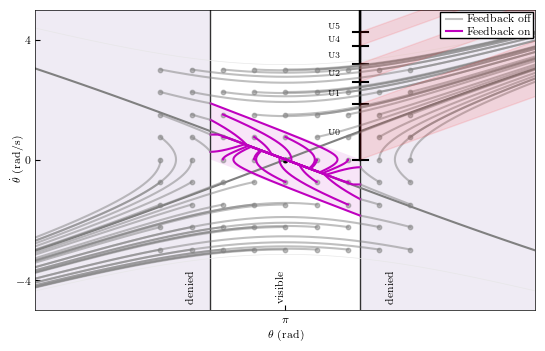

In [9]:
fig_dim = (5 ,3)
fig = plt.figure( figsize= fig_dim,dpi = 100)
 
ax0= plt.axes([ 0 , 0 , 1     ,  1] )   
 
plot_LQR_region( ax0)
ax0.set_xlim([np.pi-1,np.pi+1])
ax0.set_ylim([-5,5]) 

ff.plot_add_contours(ax0)   
    
yl = -4
ax0.text( np.pi -0.04,yl,'visible' ,rotation = 90 , fontsize = 8)  
ax0.text( np.pi -0.4,yl,'denied' ,rotation = 90 , fontsize = 8 )  
ax0.text( np.pi +0.4,yl,'denied',rotation = 90 , fontsize = 8)  
 

ax0.set_xlabel(r'$\theta$ (rad)')
ax0.set_ylabel(r'$\dot{\theta}$ (rad/s)',   va = 'top')  

 
u_list = [] 
for list in result_list:
    list[3][1]
    
    u_list.append( list[3][0])
    converge_bool = list[0]
    
    dist_err = np.abs(list[2][:,0] - np.pi)
    
    if len( np.where( dist_err > 2 )[0]) > 0:
        max_i   = np.where( dist_err > 2 )[0][0]
    else:
        max_i = len(list[2][:,0])
     
    
    if list[1]:  # in convergence 
        col = 'm'
        n_col = 'k'
        y_in = list[2][:max_i,:]
#         ax0.plot(list[2][:max_i,0], list[2][:max_i,1],color=col)

        in_lqr = (y_in[:,0] > (np.pi-0.3)) & (y_in[:,0] < (np.pi+0.3))
        ax0.plot( y_in[in_lqr,0],  y_in[in_lqr,1] ,color=col)
        ax0.plot( y_in[~in_lqr,0],  y_in[~in_lqr,1] ,color=g_col)
        
        ax0.scatter(list[2][0,0], list[2][0,1],10,color=g_col)
        
        
    else:
        g_col = np.ones((4,))*0.5
    
        ax0.plot(list[2][:max_i,0], list[2][:max_i,1],color=g_col)
        ax0.scatter(list[2][0,0], list[2][0,1],10,color=g_col)
     

ax0.plot( [0,0] , [0,1],color=g_col,  label = 'Feedback off')
# ax0.plot( [0,0] , [0,1],color=n_col, label='control off')
ax0.plot( [0,0] , [0,1],color= col ,label = 'Feedback on')

ax0.legend( )
 
ax0.scatter( np.pi,0,10,'k')
 
ff.save_fig(fig, figs_path, fig_name)  